# EU Legislation strictness analysis

**Authors:** [Gijs Jan Brandsma](http://www.ru.nl/personen/brandsma-g), [Radboud University](http://www.ru.nl/en); [Jens Blom-Hansen](https://pure.au.dk/portal/en/persons/jens-blomhansen(eb2cb20a-732b-4c55-8832-ceb762f84651).html), [Aarhus University](http://international.au.dk/)
; [Kody Moodley](https://www.esciencecenter.nl/team/dr-kody-moodley/), [The Netherlands eScience Center](https://www.esciencecenter.nl/)

**Date:** 2023-07-13

**Description:** This notebook generates plots and results related to measuring the strictness of EU legislation published from 1971 to 2022. This analysis is part of the research project [Nature of EU Rules: Strict or Lacking Bite?](https://research-software-directory.org/projects/the-nature-of-eu-rules-strict-and-detailed-or-lacking-bite). Github repository located [here](https://github.com/nature-of-eu-rules). The notion of strictness which we subscribe to in this study is the number of legal obligations (regulative phrases or statements) in the text of the legislative documents, as classified by a rule-based algorithm based on grammatical dependency analysis of sentences which contain [deontic](https://en.wikipedia.org/wiki/Deontic_modality) phrases such as "shall", "shall not", "must" and "must not".

**License:** [Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0)

## 1. Data summary and exploration

In this section we calculate some general descriptive statistics about the dataset to qualify the analyses we do later on in this notebook about strictness of EU legislation.

First we load the CSV data prepared by ```prepare-data-for-analysis.ipynb```:

In [112]:
import pandas as pd
import plotly.express as plotly

metadata_df = pd.read_csv('metadata_enriched2.csv')
print('Total number of documents: ', len(metadata_df))

Total number of documents:  119077


Interesting... there seems to be a document published in 1961 (even though our dataset officially goes from 1970 - 2022). Celex number: [31971R2050](https://eur-lex.europa.eu/legal-content/EN/ALL/?uri=CELEX:31971R2050)

We only consider 'R' (Regulation), 'L' (Directive) and 'D' (Decision), we ignore other types of documents in the corpus.

In [113]:
metadata_df = metadata_df[metadata_df['form'].isin(['R','L','D'])]
print('Total number of (R, L, D) documents: ', len(metadata_df))

Total number of (R, L, D) documents:  118623


Get descriptive statistics about number of sentences (```sent_count```), words (```word_count```) and classified legal obligations (```reg_count```) in each document in the dataset:

In [114]:
desc_cols = set(metadata_df.columns) - {'year', 'month', 'day', 'procedure_code'} # specify irrelevant columns
describe_df = metadata_df[list(desc_cols)] # remove irrelevant columns
describe_df.describe() # generate and display descriptive statistics

,sent_count,reg_count,word_count
count,118623.000000,118623.000000,118623.000000
mean,7.946022,2.096659,165.113629
std,34.721994,12.027259,840.585126
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,1.000000
50%,1.000000,0.000000,21.000000
75%,4.000000,1.000000,93.000000
max,3342.000000,1230.000000,95867.000000


How many documents do not contain any legal obligations:

In [115]:
no_legal_obligations = metadata_df[metadata_df['reg_count'] == 0]
print(len(no_legal_obligations))

85677


Wow, that is over 70% of all the documents...

The document with the most number of legal obligations is...

In [116]:
most_legal_obligations = metadata_df[metadata_df['reg_count'] == 1230.0]
print('CELEX number: ', most_legal_obligations['celex'].tolist()[0])

CELEX number:  32013R0575


calculate the global mean of strictness (i.e. on average across all documents from all years):

In [117]:
global_mean = metadata_df['reg_count'].mean()
nonzero_df = metadata_df[metadata_df['reg_count'] > 0]
mean_for_nonzero = nonzero_df['reg_count'].mean()
describe_nonzero_df = nonzero_df[list(desc_cols)] # remove irrelevant columns
describe_nonzero_df.describe()

,sent_count,reg_count,word_count
count,32946.000000,32946.000000,32946.000000
mean,24.054392,7.549080,525.013719
std,62.946452,21.901682,1534.816452
min,1.000000,1.000000,5.000000
25%,4.000000,1.000000,78.000000
50%,9.000000,2.000000,193.000000
75%,23.000000,7.000000,481.000000
max,3342.000000,1230.000000,95867.000000


In [118]:
print('Global mean number of regulations per document: ', global_mean)
print('Global mean number of regulations per document (only for docs that contain at least one): ', mean_for_nonzero)

Global mean number of regulations per document:  2.0966591639058194
Global mean number of regulations per document (only for docs that contain at least one):  7.549080313239847


Lets see the distribution of legislative documents by legal form (R, L, D). First we will prepare the preferences for plotting the graphs in this section:

In [119]:
import matplotlib.pyplot as plt
import random

metadata_df = metadata_df.astype({'year':'int'})
nonzero_df = nonzero_df.astype({'year':'int'})

SMALL_SIZE = 8
MEDIUM_SIZE = 12
MEDIUML_SIZE = 14
BIGGER_SIZE = 18

plt.rcParams['legend.title_fontsize'] = 'x-large'
# plt.rc('title', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUML_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Now plot the distribution by legal form:

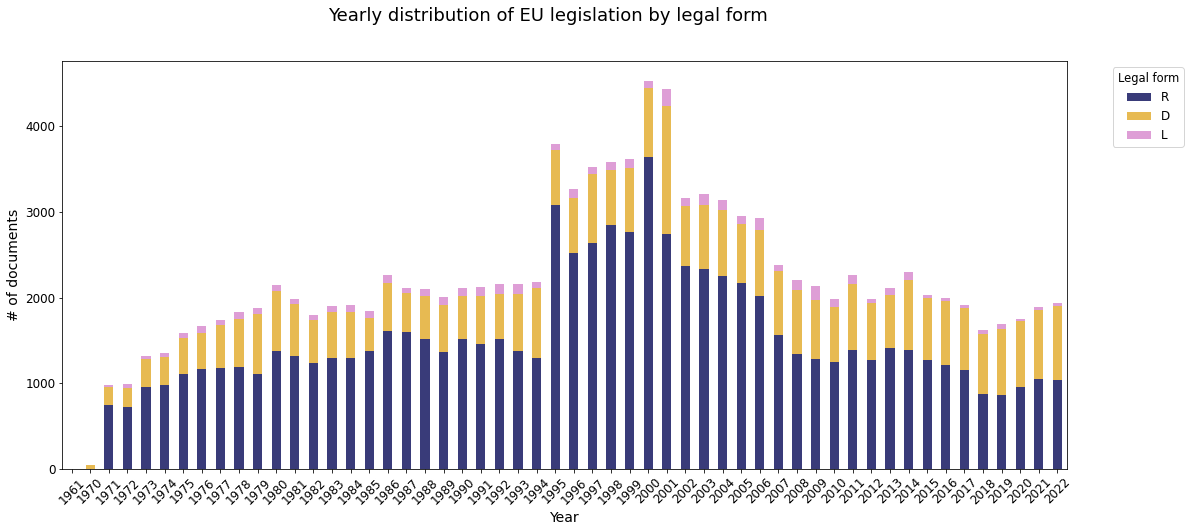

In [120]:
# group the rows by 'year' and 'category', and count the number of occurrences of each category
counts = metadata_df.groupby(['year', 'form']).size()
# unstack the multi-level index and fill any missing values with 0
counts = counts.unstack().fillna(0)
# sort the counts in descending order
top_counts = counts.sum().sort_values(ascending=False)
# filter the counts DataFrame to only include the top categories
counts = counts[top_counts.index]
# create a stacked bar plot of the counts by year
counts.plot(kind='bar', stacked=True, figsize=(18, 7.5), colormap="tab20b")
# set the plot title and labels
plt.suptitle('Yearly distribution of EU legislation by legal form')
plt.xlabel('Year')
plt.ylabel('# of documents')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="Legal form")
# show the plot
plt.savefig('generated-files/eu_legislation_distribution_over_legal_forms.png', bbox_inches='tight')
plt.show()

Now we will plot how many documents there are across year and policy area. 

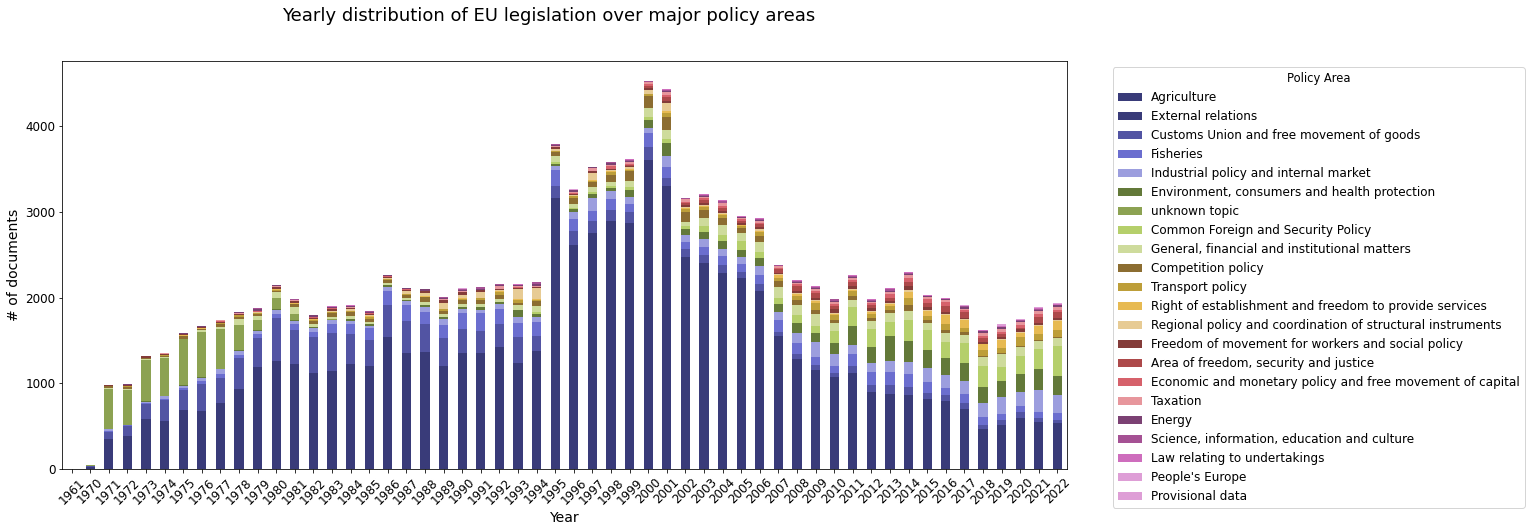

In [121]:
# group the rows by 'year' and 'category', and count the number of occurrences of each category
counts = metadata_df.groupby(['year', 'dc_string']).size()
# unstack the multi-level index and fill any missing values with 0
counts = counts.unstack().fillna(0)
# sort the counts in descending order
top_counts = counts.sum().sort_values(ascending=False)
# filter the counts DataFrame to only include the top categories
counts = counts[top_counts.index]
# create a stacked bar plot of the counts by year
counts.plot(kind='bar', stacked=True, figsize=(18, 7.5), colormap="tab20b")
# set the plot title and labels
plt.suptitle('Yearly distribution of EU legislation over major policy areas')
plt.xlabel('Year')
plt.ylabel('# of documents')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="Policy Area")
# show the plot
plt.savefig('generated-files/eu_legislation_distribution_over_policy_areas.png', bbox_inches='tight')
plt.show()

Apart from Agriculture (the most prevalent policy area by far) what is the distribution of documents by policy areas and year?

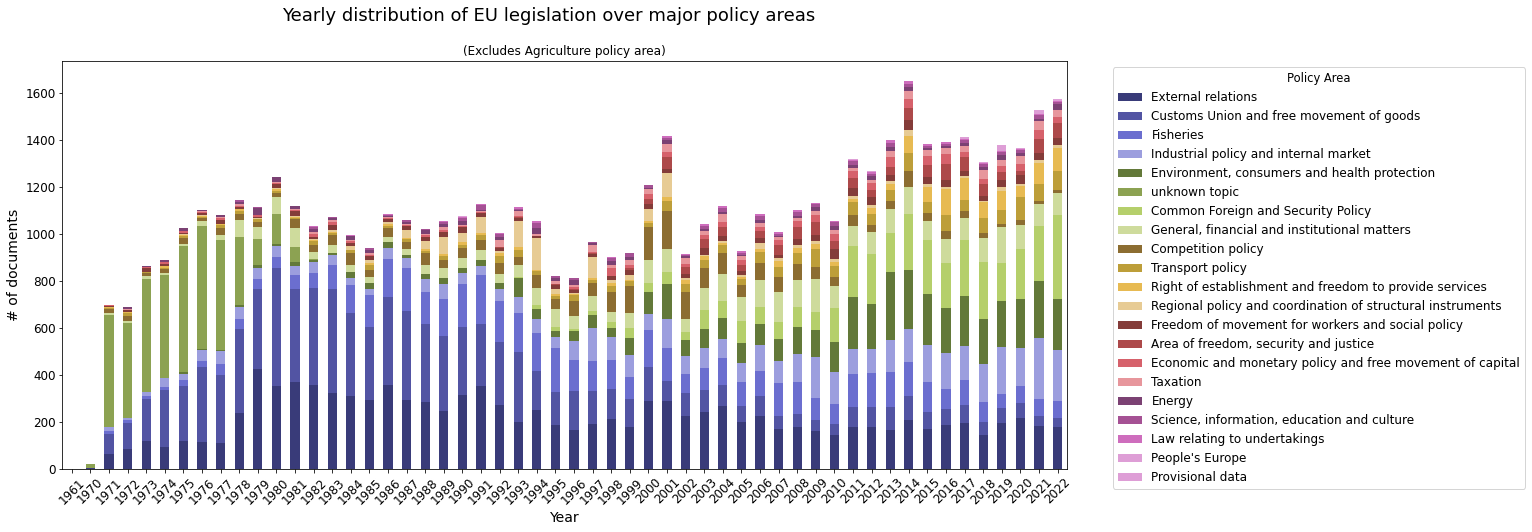

In [122]:
no_agri_df = metadata_df[~metadata_df['dc_string'].isin(['Agriculture'])]
counts = no_agri_df.groupby(['year', 'dc_string']).size()
counts = counts.unstack().fillna(0)
top_counts = counts.sum().sort_values(ascending=False)
counts = counts[top_counts.index]
counts.plot(kind='bar', stacked=True, figsize=(18, 7.5), colormap="tab20b")
plt.suptitle('Yearly distribution of EU legislation over major policy areas')
plt.title('(Excludes Agriculture policy area)', fontsize=MEDIUM_SIZE)
plt.xlabel('Year')
plt.ylabel('# of documents')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="Policy Area")
plt.savefig('generated-files/eu_legislation_distribution_over_policy_areas_noagri.png', bbox_inches='tight')
plt.show()

Let us repeat the two plots above by limiting our focus to only those documents which contain at least one legal obligation for a specific agent:

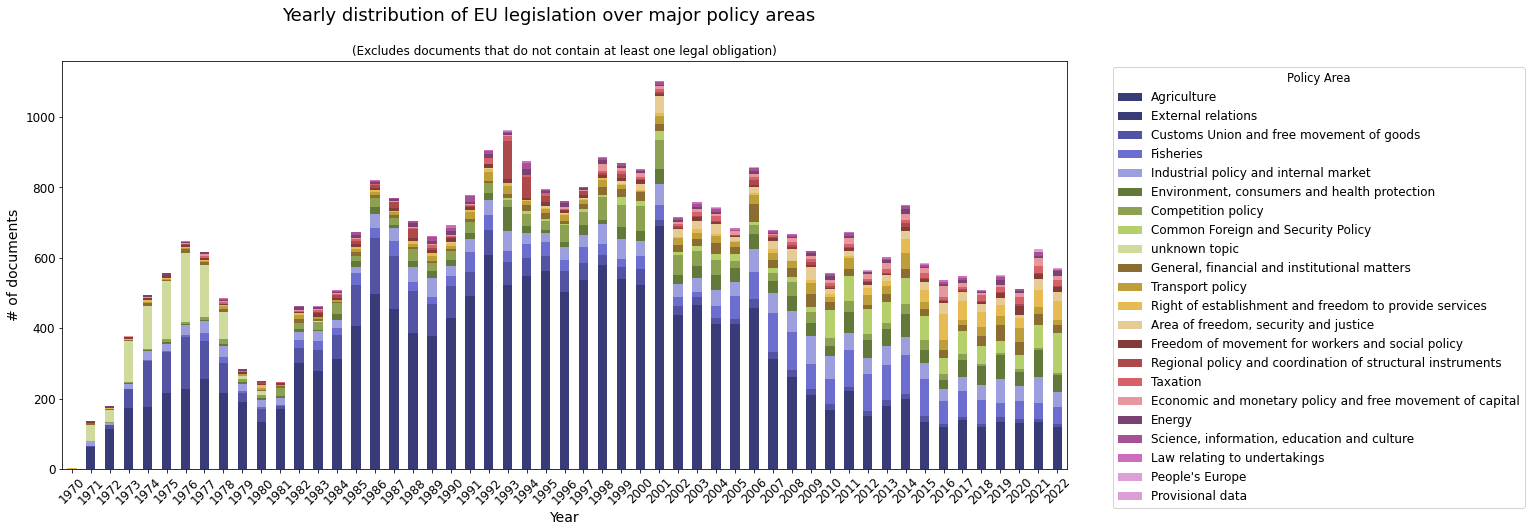

In [123]:
counts = nonzero_df.groupby(['year', 'dc_string']).size()
counts = counts.unstack().fillna(0)
top_counts = counts.sum().sort_values(ascending=False)
counts = counts[top_counts.index]
counts.plot(kind='bar', stacked=True, figsize=(18, 7.5), colormap="tab20b")
plt.suptitle('Yearly distribution of EU legislation over major policy areas')
plt.title('(Excludes documents that do not contain at least one legal obligation)', fontsize=MEDIUM_SIZE)
plt.xlabel('Year')
plt.ylabel('# of documents')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="Policy Area")
plt.savefig('generated-files/eu_legislation_distribution_over_policy_areas_onlyregdocs.png', bbox_inches='tight')
plt.show()

And similarly removing Agriculture from consideration:

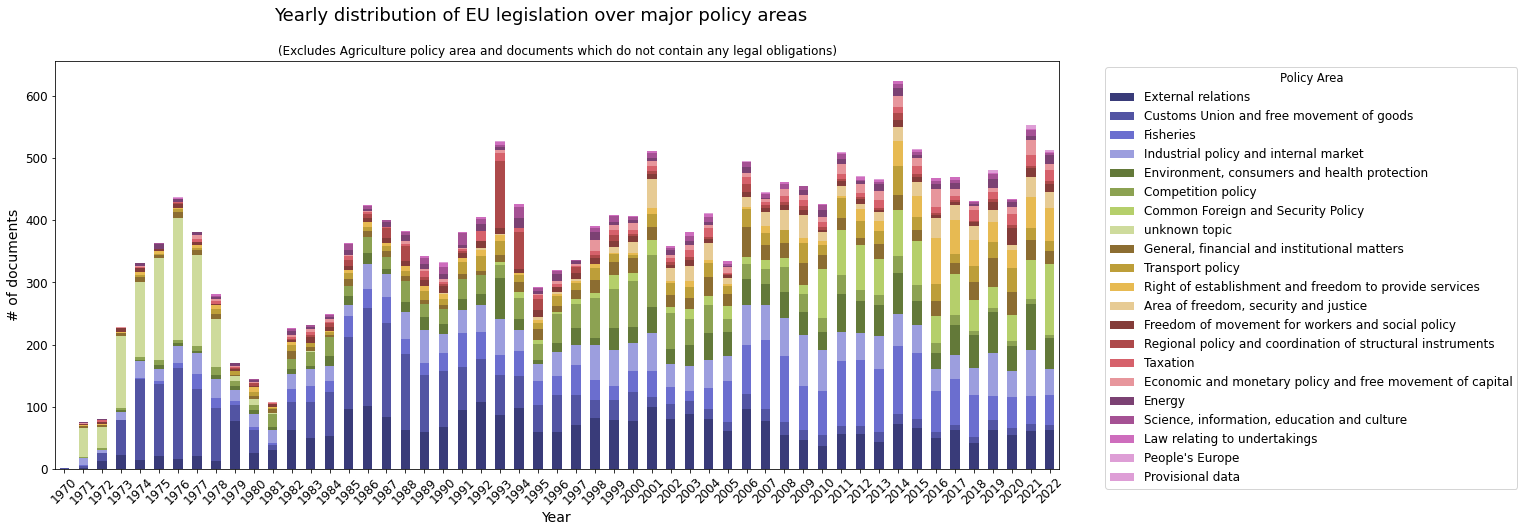

In [124]:
no_agri_nonzero_df = nonzero_df[~nonzero_df['dc_string'].isin(['Agriculture'])]
counts = no_agri_nonzero_df.groupby(['year', 'dc_string']).size()
counts = counts.unstack().fillna(0)
top_counts = counts.sum().sort_values(ascending=False)
counts = counts[top_counts.index]
counts.plot(kind='bar', stacked=True, figsize=(18, 7.5), colormap="tab20b")
plt.suptitle('Yearly distribution of EU legislation over major policy areas')
plt.title('(Excludes Agriculture policy area and documents which do not contain any legal obligations)', fontsize=MEDIUM_SIZE)
plt.xlabel('Year')
plt.ylabel('# of documents')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="Policy Area")
plt.savefig('generated-files/eu_legislation_distribution_over_policy_areas_onlyregdocs_noagri.png', bbox_inches='tight')
plt.show()

## 2. Strictness analysis over time

In this section we plot the mean strictness per year or date (day). That is, the average number of legal obligations per document in that year (or day).

group the average number of legal obligations by year (regardless of legal form for now):

In [125]:
# Set this to True to analyse only documents which contain at least one legal obligation
# Set it to False to include the remainder of the dataset (i.e., those documents that do not contain any legal obligations)
nonzero_flag = False

strictness_metric = 'count' # possible values: ['count', 'average']
metric_col = 'total_reg_count'
if strictness_metric != 'count':
    metric_col = 'avg_reg_count'
    
df = None

if nonzero_flag:
    df = metadata_df[metadata_df['reg_count'] > 0]
else:
    df = metadata_df
    
time_column = 'year' # possible values: ['year', 'date']

mean_years_noform = None

if strictness_metric == 'count':
    mean_years_noform = df.groupby([time_column])['reg_count'].count()    
    no_ind_noform = mean_years_noform.reset_index(drop=False)
else:
    mean_years_noform = df.groupby([time_column])['reg_count'].mean(numeric_only=True)
    no_ind_noform = mean_years_noform.reset_index(drop=False)
        
avg_reg_count_by_year_noform = pd.DataFrame(no_ind_noform.values.tolist(), columns=[time_column, metric_col])
max_time = avg_reg_count_by_year_noform[avg_reg_count_by_year_noform[metric_col] == avg_reg_count_by_year_noform[metric_col].max()]
# Out of interest, what is the year or date with the maximum value for total number of legal obligations?
print(max_time[time_column].tolist())


[2000]


define a generic function to plot line graphs:

In [126]:
def plot_line_graph(df, xcol, ycol, labels, w, h, title, filepath, color='', color_discrete_sequence=''):
    if ycol == 'avg_reg_count':
        title = "Mean " + title
    else:
        title = "Total " + title
        
    if color == '':
        if color_discrete_sequence == '':
            myFigure = plotly.line(df, x=xcol, y=ycol, width=w, height=h, labels=labels, title=title)
        else:
            myFigure = plotly.line(df, x=xcol, y=ycol, width=w, height=h, labels=labels, title=title, color_discrete_sequence=color_discrete_sequence)
    else:
        if color_discrete_sequence == '':
            myFigure = plotly.line(df, x=xcol, y=ycol, width=w, height=h, labels=labels, title=title, color=color)
        else:
            myFigure = plotly.line(df, x=xcol, y=ycol, width=w, height=h, labels=labels, title=title, color=color, color_discrete_sequence=color_discrete_sequence)
    myFigure.update_xaxes(tickmode='linear', tickangle=60)
    myFigure.write_image(filepath)
    myFigure.show()

plot and save graph which measures mean strictness over the years (regardless of other criteria):

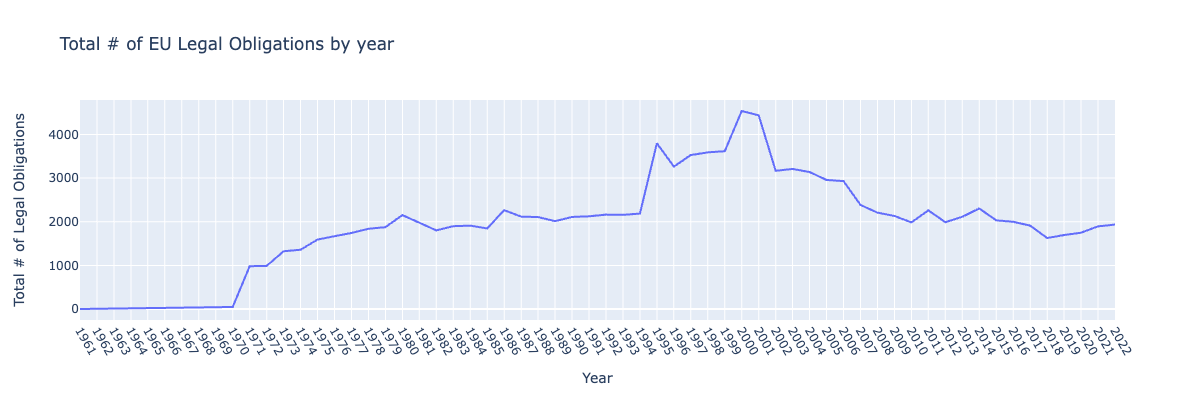

In [127]:
plot_line_graph(avg_reg_count_by_year_noform, xcol=time_column, ycol=metric_col, w=1200, h=400, labels={
                     "year": "Year",
                     "date" : "Day",
                     "avg_reg_count" : "Mean # of Legal Obligations",
                     "total_reg_count" : "Total # of Legal Obligations"
                 }, title="# of EU Legal Obligations by {}".format(time_column), filepath="generated-files/{}_legal_obligations_by_{}.png".format(strictness_metric, time_column))


## 3. Strictness analysis by year and legal form

...now we group results by legal form as well.


In [128]:
mean_years = None
if strictness_metric == 'count':
    mean_years = df.groupby([time_column, 'form'])['reg_count'].count()
    no_ind = mean_years.reset_index(drop=False)
else:
    mean_years = df.groupby([time_column, 'form'])['reg_count'].mean(numeric_only=True)
    no_ind = mean_years.reset_index(drop=False)
        
avg_reg_count_by_year = pd.DataFrame(no_ind.values.tolist(), columns=[time_column, 'form', metric_col])

plot the graph...

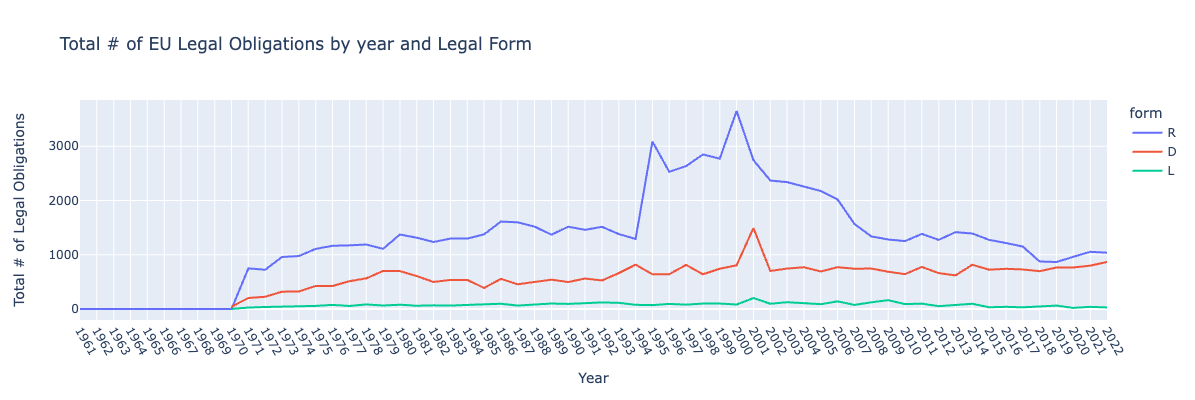

In [129]:
plot_line_graph(avg_reg_count_by_year, xcol=time_column, ycol=metric_col, w=1200, h=400, labels={
                     "year": "Year",
                     "date" : "Day",
                     "avg_reg_count" : "Mean # of Legal Obligations",
                     "total_reg_count" : "Total # of Legal Obligations"
                 }, title="# of EU Legal Obligations by {} and Legal Form".format(time_column), color="form", filepath="generated-files/{}_legal_obligations_by_{}_and_form.png".format(strictness_metric, time_column))


## 4. Strictness analysis by year and policy area
Now we analyse the strictness over time grouped by policy area only.

First let's prepare or group the dataframe legal topic (policy area e.g. agriculture, taxation etc.). ```dc_string``` is the column which holds the (most general) legal topic:


In [130]:
mean_years_policy = None
if strictness_metric == 'count':
    mean_years_policy = df.groupby([time_column, 'dc_string'])['reg_count'].count()
    no_ind_policy = mean_years_policy.reset_index(drop=False)
else:
    mean_years_policy = df.groupby([time_column, 'dc_string'])['reg_count'].mean(numeric_only=True)
    no_ind_policy = mean_years_policy.reset_index(drop=False)
        
avg_reg_count_by_year_policy = pd.DataFrame(no_ind_policy.values.tolist(), columns=[time_column, 'dc_string', metric_col])

# mean_years_policy = df.groupby(['year', 'dc_string'])['reg_count'].mean(numeric_only=True)
# no_ind_policy = mean_years_policy.reset_index(drop=False)
# avg_reg_count_by_year_policy = pd.DataFrame(no_ind_policy.values.tolist(), columns=['year', 'dc_string', 'avg_reg_count'])

plot this graph...

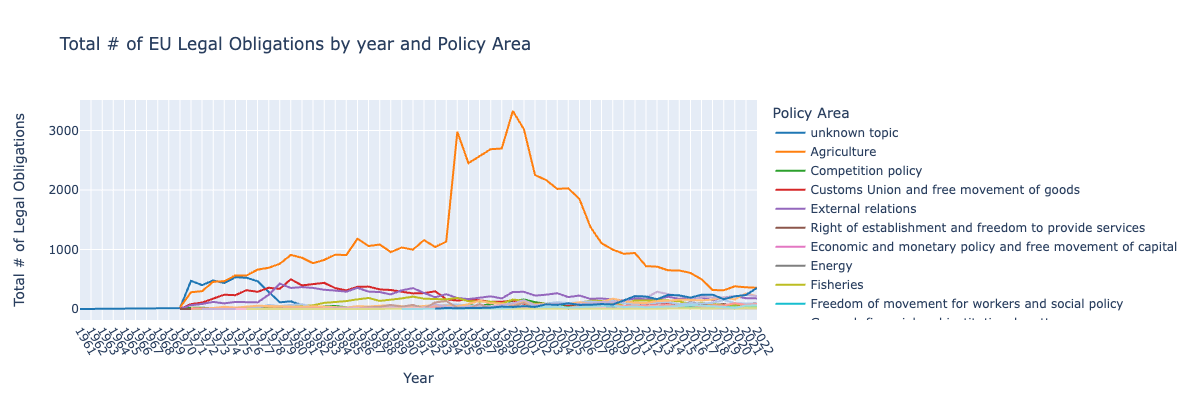

In [131]:
custom_palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', 
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5'
]

plot_line_graph(avg_reg_count_by_year_policy, xcol=time_column, ycol=metric_col, w=1300, h=400, labels={
                     "year": "Year",
                     "avg_reg_count": "Mean # of Legal Obligations",
                     "total_reg_count": "Total # of Legal Obligations",
                     "dc_string": "Policy Area"
                 }, title="# of EU Legal Obligations by {} and Policy Area".format(time_column), color="dc_string", filepath="generated-files/{}_legal_obligations_by_{}_and_policyarea.png".format(strictness_metric, time_column), color_discrete_sequence=custom_palette)


Plot separate graphs for each policy area:

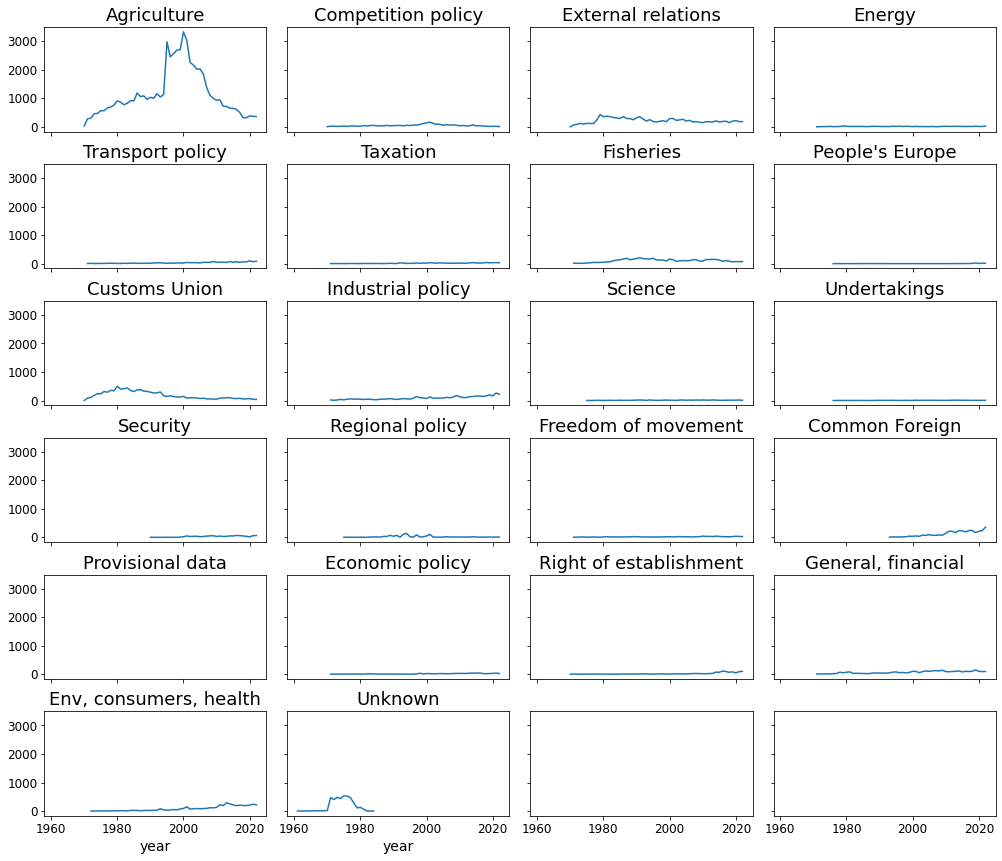

In [132]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20), (ax21, ax22, ax23, ax24)) = plt.subplots(nrows=6, ncols=4, sharex=True, sharey=True, figsize=(14,12))

# Doing each of these manually (ugh)
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Agriculture'].plot(x=time_column, y=metric_col, legend=False, ax=ax1)
ax1.set_title("Agriculture")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Competition policy'].plot(x=time_column, y=metric_col, legend=False, ax=ax2)
ax2.set_title("Competition policy")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'External relations'].plot(x=time_column, y=metric_col, legend=False, ax=ax3)
ax3.set_title("External relations")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Energy'].plot(x=time_column, y=metric_col, legend=False, ax=ax4)
ax4.set_title("Energy")

avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Transport policy'].plot(x=time_column, y=metric_col, legend=False, ax=ax5)
ax5.set_title("Transport policy")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Taxation'].plot(x=time_column, y=metric_col, legend=False, ax=ax6)
ax6.set_title("Taxation")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Fisheries'].plot(x=time_column, y=metric_col, legend=False, ax=ax7)
ax7.set_title("Fisheries")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == "People's Europe"].plot(x=time_column, y=metric_col, legend=False, ax=ax8)
ax8.set_title("People's Europe")

avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Customs Union and free movement of goods'].plot(x=time_column, y=metric_col, legend=False, ax=ax9)
ax9.set_title("Customs Union")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Industrial policy and internal market'].plot(x=time_column, y=metric_col, legend=False, ax=ax10)
ax10.set_title("Industrial policy")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Science, information, education and culture'].plot(x=time_column, y=metric_col, legend=False, ax=ax11)
ax11.set_title("Science")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == "Law relating to undertakings"].plot(x=time_column, y=metric_col, legend=False, ax=ax12)
ax12.set_title("Undertakings")

avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Area of freedom, security and justice'].plot(x=time_column, y=metric_col, legend=False, ax=ax13)
ax13.set_title("Security")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Regional policy and coordination of structural instruments'].plot(x=time_column, y=metric_col, legend=False, ax=ax14)
ax14.set_title("Regional policy")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Freedom of movement for workers and social policy'].plot(x=time_column, y=metric_col, legend=False, ax=ax15)
ax15.set_title("Freedom of movement")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == "Common Foreign and Security Policy"].plot(x=time_column, y=metric_col, legend=False, ax=ax16)
ax16.set_title("Common Foreign")

avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Provisional data'].plot(x=time_column, y=metric_col, legend=False, ax=ax17)
ax17.set_title("Provisional data")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Economic and monetary policy and free movement of capital'].plot(x=time_column, y=metric_col, legend=False, ax=ax18)
ax18.set_title("Economic policy")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Right of establishment and freedom to provide services'].plot(x=time_column, y=metric_col, legend=False, ax=ax19)
ax19.set_title("Right of establishment")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == "General, financial and institutional matters"].plot(x=time_column, y=metric_col, legend=False, ax=ax20)
ax20.set_title("General, financial")

avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == 'Environment, consumers and health protection'].plot(x=time_column, y=metric_col, legend=False, ax=ax21)
ax21.set_title("Env, consumers, health")
avg_reg_count_by_year_policy[avg_reg_count_by_year_policy['dc_string'] == "unknown topic"].plot(x=time_column, y=metric_col, legend=False, ax=ax22)
ax22.set_title("Unknown")

# If we don't do tight_layout() there can be strange rendering issues such as overlapping diagrams or text
plt.tight_layout()
plt.savefig('generated-files/legal_obligations_by_{}_separate_plots_for_policyareas.png'.format(time_column))

## 5. Strictness analysis by legal form and policy area
Now we analyse the strictness over based on legal form and policy are using a heatmap. This view can give insight into, for example, if Agriculture regulations are more strict than External relations decisions or directives.

First prepare the dataframe with only the data we need to plot the heatmap (only need form, year, policy area and mean number of regulatory statements):

In [133]:
mean_years_policy_form = None
if strictness_metric == 'count':
    mean_years_policy_form = df.groupby([time_column, 'form', 'dc_string'])['reg_count'].count()
    no_ind_policy_form = mean_years_policy_form.reset_index(drop=False)
else:
    mean_years_policy_form = df.groupby([time_column, 'form', 'dc_string'])['reg_count'].mean(numeric_only=True)
    no_ind_policy_form = mean_years_policy_form.reset_index(drop=False)
        
avg_reg_count_by_year_policy_form = pd.DataFrame(no_ind_policy_form.values.tolist(), columns=[time_column, 'form', 'dc_string', metric_col])
# mean_years_policy_form = df.groupby([time_column, 'form', 'dc_string'])['reg_count'].mean(numeric_only=True)
# no_ind_policy_form = mean_years_policy_form.reset_index(drop=False)
# avg_reg_count_by_year_policy_form = pd.DataFrame(no_ind_policy_form.values.tolist(), columns=['year', 'form', 'dc_string', 'avg_reg_count'])

Now prepare the data (pivot the dataframe) to put it in a format for rendering in a heatmap (2D matrix):

In [134]:
df_heatmap = avg_reg_count_by_year_policy_form.pivot_table(values=metric_col,index='dc_string',columns='form')


Now plot the heatmap:

Text(0.5, 111.0, 'Legal Form')

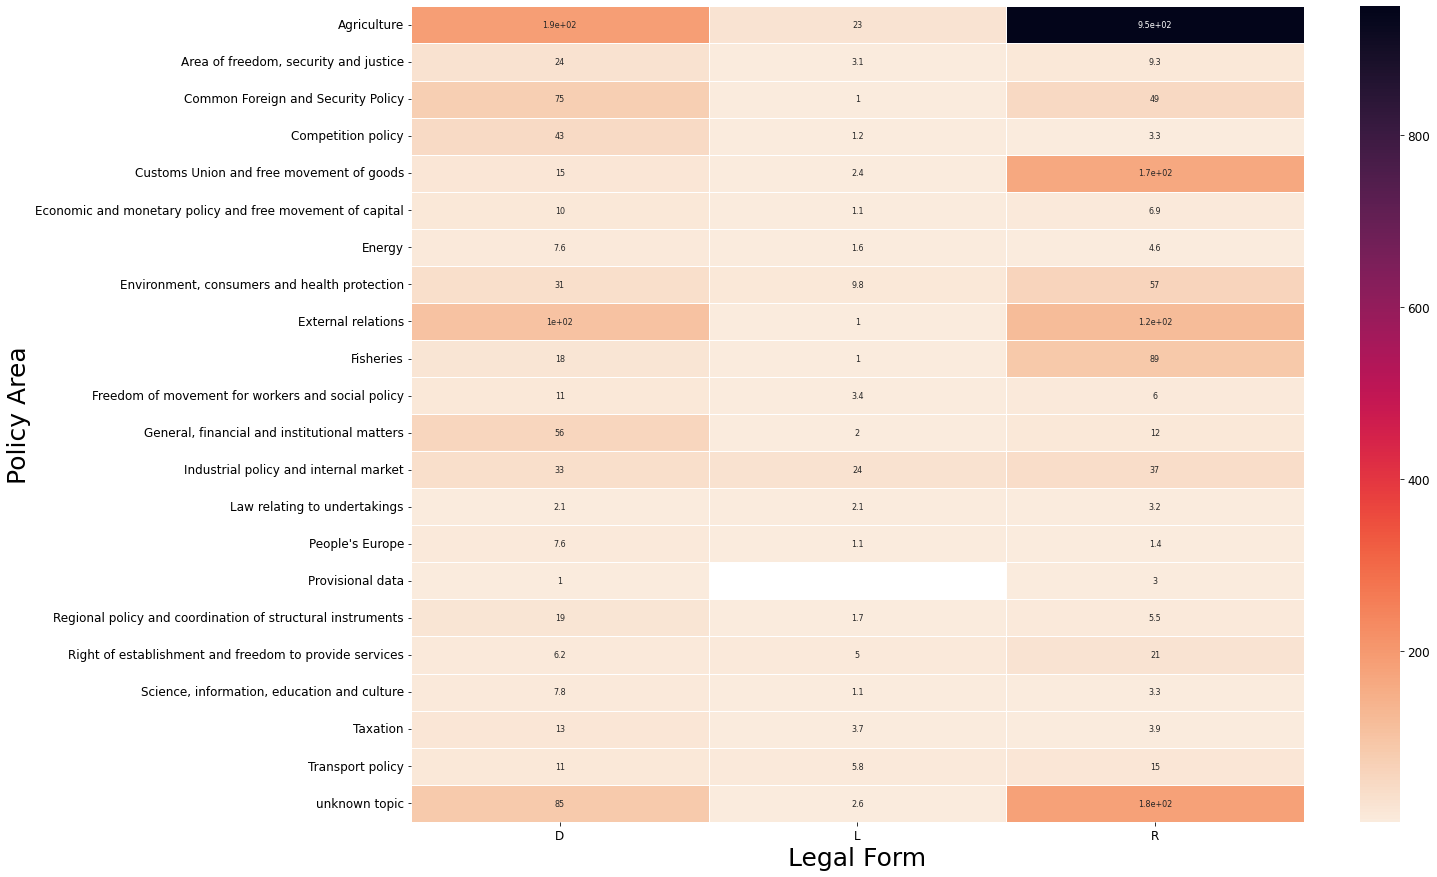

In [135]:
import seaborn as sns
plt.subplots(figsize=(20,15))
s = sns.heatmap(df_heatmap, cmap ='rocket_r', linewidths = 0.50, annot = True)
s.set_ylabel('Policy Area', fontsize=25)
s.set_xlabel('Legal Form', fontsize=25)